# Hood Snow Data Visualization

This notebook has the useful bits of `explore.ipynb`, and relies on the data in `prepared_data.csv` and `prepared_weather.csv`. I used this notebook to prepare the heatmap and graphs for my poster. I tried to comment enough to explain what's going on.

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from pathlib import Path
sb.set_theme(style="whitegrid", font="NotoSans Nerd Font")

DATA = Path("E:/sensing/hood_snow/data").resolve()

MAX_CLOUDS = 0.4  # 40% cloud cover is max acceptable
SNOWLINE_CRIT = 0.4  # 40% snow coverage is where the snowline falls

FIG_WIDTH_IN = 16
FIG_HEIGHT_IN = 4

In [2]:
# this data was already cleaned in the following ways:
# - dropped all contours < 1300m (they're mostly NULL pct_snow due to AOI)
# - dropped 2018-08-16 (imagery for this date is misaligned)
data = pd.read_csv(DATA.joinpath("prepared_data.csv"))
data.head()

,date,contour,pct_snow,pct_clouds
0,2017-01-03,1300,0.626,0.501
1,2017-01-03,1400,0.619,0.501
2,2017-01-03,1500,0.721,0.501
3,2017-01-03,1600,0.745,0.501
4,2017-01-03,1700,0.808,0.501


In [3]:
# this weather was prepared by making the ski resort weather telemetry
# match the format of the snotel telemetry. Ski weather was aggregated per-day
# with mean/min/max on temperature, sum on precipitation, and max on snow_depth.
# This data also cleaned by dropping temp values in the 0.1 percentile (very low outliers).
# NOTE: that snow_depth != snow_water, which is why they're separate columns.
# data units are US customary (inches, ⁰F)
weather = pd.read_csv(DATA.joinpath("prepared_weather.csv"))
# snow_depth, a measurement at Timberline Lodge, is VERY noisy in the summers
# with very high values. This cleans most of them, but there are a few other
# bad values in the data that are not as easy to remove. However, I don't think
# they will affect my intended use of this field.
weather = weather.drop(weather[weather.snow_depth >= 250].index)
weather.head()

,place,date,precip,temp_avg,temp_min,temp_max,snow_water,snow_depth,elev
0,Snotel,2017-01-03,48.3,12.4,9.9,15.1,26.0,NaN,1635
1,Snotel,2017-01-04,48.3,14.0,9.0,17.6,25.6,NaN,1635
2,Snotel,2017-01-05,48.3,20.7,15.6,25.3,24.2,NaN,1635
3,Snotel,2017-01-06,48.3,23.5,13.1,31.5,24.2,NaN,1635
4,Snotel,2017-01-07,48.3,20.8,12.6,33.6,24.2,NaN,1635


In [4]:
def drop_clouds(data: pd.DataFrame, max_clouds_pct: float = 1, pct_clouds_col: str = "pct_clouds") -> pd.DataFrame:
    """Drop data with percent cloud coverage greater than `max_clouds`."""
    return data.drop(data.loc[data[pct_clouds_col] > max_clouds_pct].index)  # drop cloudy days


def date_str_to_dt(df: pd.DataFrame) -> pd.DataFrame:
    """convert "date" column from string to datetime"""
    df["date"] = pd.to_datetime(df["date"])
    return df


def format_date_ticks(old_ticks: list[plt.Text], fmt: str = "%Y-%m") -> list[str]:
    """ change datetime ticks from default format to the one specified in `fmt`."""
    text = [l.get_text() for l in old_ticks]
    return pd.to_datetime(text).strftime(fmt)


def create_heatmap(data: pd.DataFrame,
                   max_cloud_pct: float = 1,
                   date_col: str = "date", contour_col: str = "contour", pct_snow_col: str = "pct_snow",
                   ax: plt.Axes = None, cmap="viridis", cbar: bool = False) -> plt.Axes:
    """
    create a heatmap of data with date on the x axis and contour on the y axis. 
    rows with more than `max_clouds_pct` will be dropped.
    """
    # massage data
    fewer_clouds = drop_clouds(data, max_cloud_pct)
    fewer_clouds = date_str_to_dt(fewer_clouds)
    data_heatmap = (fewer_clouds
                    .pivot(index=contour_col, columns=date_col, values=pct_snow_col)
                    .sort_index(axis=0, ascending=False))
    # create the actual heatmap
    ax = sb.heatmap(data_heatmap, cmap=cmap, ax=ax, cbar=cbar)
    # format axes labels
    ax.set_xticklabels(format_date_ticks(ax.get_xticklabels()))
    ax.set_title(f"Snow coverage when cloud cover {max_cloud_pct*100:.0f}% or less")
    ax.set_ylabel("Elevation (m)")
    ax.set_xlabel("Date")
    return ax

# ax:plt.Axes= create_heatmap(data,max_cloud_pct=MAX_CLOUDS)

In [5]:
def find_snowline_elevation(data: pd.DataFrame, critical_snow_pct: float,
                            date_col: str = "date", contour_col: str = "contour", snow_col: str = "pct_snow") -> pd.DataFrame:
    """
    find the contour level at which the snow level first falls below some
    "critical" percentage. 0.3 or 0.4 seem to be fine.
        __this is the "snowline"__

    return a new dataframe with the snowline elevation contour for each date.
    """
    reshaped = data.pivot(index=date_col, columns=contour_col, values=snow_col)
    critical_levels = []
    for date in reshaped.index:
        # help smooth data
        # for each contour level, take the mean of the next lower to next higher
        # this is a 2D "focal statistic"
        # actually don't. doesn't seem to help at all
        window_mean = reshaped.loc[date]  # .rolling(window=3, center=True).mean()
        # idxmax() is weird here, but since True is max of bool, this finds the
        # index of the first True
        level = window_mean.gt(critical_snow_pct).idxmax()
        critical_levels.append((date, level, critical_snow_pct))

    return pd.DataFrame(critical_levels, columns=["date", "contour", "critical"])


def calc_snowline_movement(data_levels: pd.DataFrame, min_contour: int = 1300,
                           date_col: str = "date", contour_col: str = "contour") -> pd.DataFrame:
    """
    use a dataframe of the snowline elevation at each date (output from
    `find_snowline_elevation()`) and find in each year the first date at which
    the snowline is above `min_countour` and the date of the maximum snowline.
    Then use that information to calculate the time period, elevation difference,
    and rate of the change (meters per day).

    return a new dataframe with these data per year.
    """
    levels = data_levels.copy()
    levels["year"] = pd.to_datetime(levels[date_col]).dt.year

    def year_snowline_movement(year: int) -> pd.Series:
        begin_idx = levels[levels["year"] == year][contour_col].gt(min_contour).idxmax()
        begin_idx -= 1  # prev line finds next idx after min_contour, so get previous
        end_idx = levels[levels["year"] == year][contour_col].idxmax()
        begin = pd.to_datetime(levels.loc[begin_idx, date_col])
        end = pd.to_datetime(levels.loc[end_idx, date_col])
        span = end - begin
        low = levels.loc[begin_idx, contour_col]
        high = levels.loc[end_idx, contour_col]
        elev_diff = high - low
        return pd.Series({
            "year": year,
            "begin": begin,
            "end": end,
            "span": span,
            "low": low,
            "high": high,
            "elev_diff": elev_diff,
            "rate": elev_diff/span.days})

    return pd.DataFrame([year_snowline_movement(year)
                         for year in levels["year"].unique()])

In [6]:
snowline = find_snowline_elevation(drop_clouds(data, MAX_CLOUDS), SNOWLINE_CRIT)
display(snowline)


def snowline_lineplot(snowline: pd.DataFrame, ax: plt.Axes = None, color: str = None) -> plt.Axes:
    """create the main lineplot showing the snowline elevation vs time."""
    sl = date_str_to_dt(snowline)
    pal = sb.color_palette() if color is None else sb.color_palette([color])
    # setting hue here is a hack to get palette to be used
    ax = sb.lineplot(sl, x="date", y="contour", hue="critical",
                     legend=False,
                     ax=ax, palette=pal)
    ax.set_xlabel("Date")
    ax.set_ylabel("Elevation (m)")
    ax.set_ylim(bottom=1200, top=3000)  # default sucked
    return ax

,date,contour,critical
0,2017-05-03,1300,0.4
1,2017-05-23,1300,0.4
2,2017-07-02,1700,0.4
3,2017-07-17,1800,0.4
4,2017-07-22,1900,0.4
...,...,...,...
203,2023-11-08,1300,0.4
204,2023-11-18,1700,0.4
205,2023-11-23,1500,0.4
206,2023-11-28,1700,0.4


In [7]:
snowline_movement = calc_snowline_movement(snowline)
display(snowline_movement)


def snowline_movement_lines(snowline_movement: pd.DataFrame, color: str = None, ax: plt.Axes = None) -> plt.Axes:
    """
    Annotates ax with lines showing the movement in each year. 
    Reshapes data to create 2 points for each year.
    """
    snlm = snowline_movement.set_index("year")
    frames = []
    for year in snlm.index:
        s = snlm.loc[year]
        d = pd.DataFrame([
            (year, s.begin, s.low),
            (year, s.end, s.high)], columns=["year", "date", "elev"])
        d = date_str_to_dt(d)
        frames.append(d)
    snlm = pd.concat(frames).reset_index(drop=True)
    # display(snlm)

    pal = sb.color_palette() if color is None else sb.color_palette([color])
    return sb.lineplot(snlm, x="date", y="elev", hue="year",
                       legend=False, palette=pal, lw=6,  ax=ax)

,year,begin,end,span,low,high,elev_diff,rate
0,2017,2017-05-23,2017-08-31,100 days,1300,2200,900,9.000000
1,2018,2018-05-13,2018-09-05,115 days,1300,2600,1300,11.304348
2,2019,2019-05-13,2019-09-05,115 days,1300,2600,1300,11.304348
3,2020,2020-06-01,2020-10-09,130 days,1300,2800,1500,11.538462
4,2021,2021-06-01,2021-09-24,115 days,1300,2400,1100,9.565217
5,2022,2022-06-21,2022-09-24,95 days,1300,2600,1300,13.684211
6,2023,2023-05-22,2023-09-09,110 days,1300,2700,1400,12.727273


In [8]:
def date_to_week(row: pd.Series) -> pd.Series:
    """Change dates in the same ISO week to the same date for aggregation."""
    d = pd.to_datetime(row["date"]).strftime("%Y-%W-0")
    row["date_week"] = pd.to_datetime(d, format="%Y-%W-%w")
    return row


def create_temp_lineplot(weather: pd.DataFrame, places: list[str], ax: plt.Axes = None) -> plt.Axes:
    """Create the plot of temperature vs time. `places` determines which stations are plotted."""
    # calculate weekly mean temp
    w = (weather
         .apply(lambda r: date_to_week(r), axis=1)
         .groupby(["place", "date_week"])["temp_avg"]
         .mean())
    w = w.loc[places]
    w = w.reset_index()

    legend = len(places) > 1
    ax: plt.Axes = sb.lineplot(w, x="date_week", y="temp_avg", hue="place", legend=legend, ax=ax)
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (⁰F)")
    ax.set_title("Weekly mean temperature")
    if legend:
        ax.get_legend().set_title("Place")
    return ax


# create_temp_lineplot(weather, places=["Snotel"])

In [9]:
def find_no_snow_date(weather: pd.DataFrame, snow_amount_col: str = "snow_water", amount_cutoff: float = 25,  date_col: str = "date") -> pd.DataFrame:
    """
    Finds the date in each year when the snow is gone at a weather station.
    Does this by finding the first date/index where the snow amount falls
    below a specified value.
    """
    # amount_cutoff=1 works ok for snow_water (snotel)
    # amount_cutoff=25 works ok for snow_depth (lodge)
    w = weather.drop(index=weather[weather[snow_amount_col].isna()].index)
    w = date_str_to_dt(w)
    w["year"] = w[date_col].dt.year
    found = []
    for y in w["year"].unique():
        first = w[w["year"] == y][snow_amount_col].lt(amount_cutoff).idxmax()
        found.append(w.loc[first][["year", "date", snow_amount_col, "place", "elev"]])
    return pd.DataFrame(found)


# do just one location
no_snow = find_no_snow_date(weather, snow_amount_col="snow_depth", amount_cutoff=25)
display(no_snow)

# run both locations with snow amount information, drop disparate columns, and merge
all_no_snow = pd.concat([
    find_no_snow_date(weather, snow_amount_col="snow_water",
                      amount_cutoff=1).drop(columns=["snow_water"]),
    find_no_snow_date(weather, snow_amount_col="snow_depth",
                      amount_cutoff=25).drop(columns=["snow_depth"]),
])
display(all_no_snow)

,year,date,snow_depth,place,elev
7915,2017,2017-07-16,21.1,Lodge,1770
8258,2018,2018-06-24,22.4,Lodge,1770
8617,2019,2019-06-18,24.1,Lodge,1770
9000,2020,2020-07-05,24.2,Lodge,1770
9315,2021,2021-06-27,23.4,Lodge,1770
9632,2022,2022-08-30,3.8,Lodge,1770
9928,2023,2023-06-22,24.2,Lodge,1770
10121,2024,2024-01-01,26.6,Lodge,1770


,year,date,place,elev
178,2017,2017-06-30,Snotel,1635
521,2018,2018-06-08,Snotel,1635
889,2019,2019-06-11,Snotel,1635
1266,2020,2020-06-22,Snotel,1635
1631,2021,2021-06-22,Snotel,1635
2015,2022,2022-07-11,Snotel,1635
2351,2023,2023-06-12,Snotel,1635
2554,2024,2024-01-01,Snotel,1635
7915,2017,2017-07-16,Lodge,1770
8258,2018,2018-06-24,Lodge,1770


## Create snow coverage heatmap

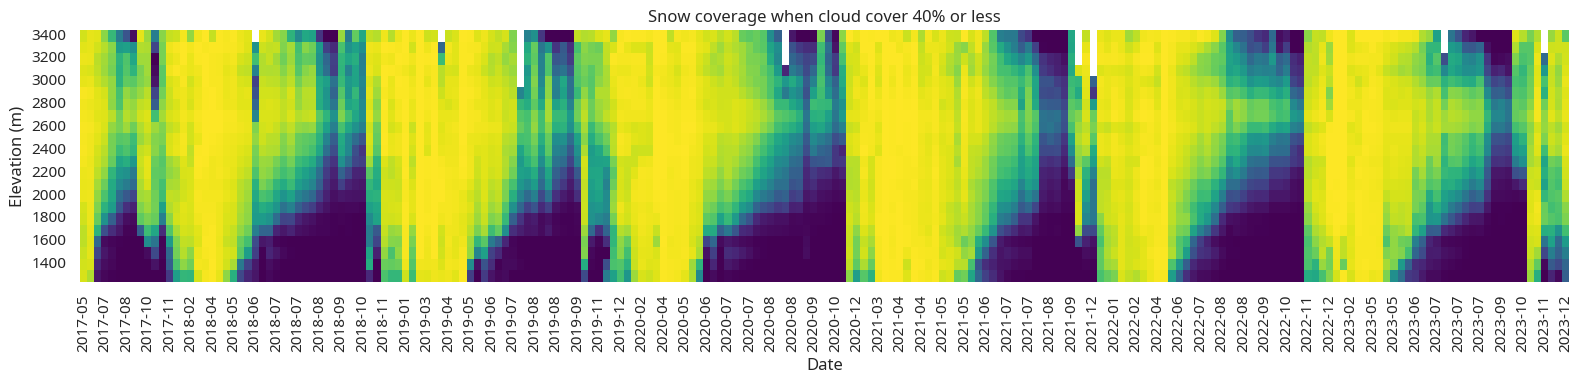

In [10]:
PLOT_ROWS = 1
fig, axes = plt.subplots(nrows=PLOT_ROWS)
fig.set_size_inches(w=FIG_WIDTH_IN, h=FIG_HEIGHT_IN*PLOT_ROWS)

# create_heatmap(data, max_cloud_pct=1.0, ax=axes[0])
create_heatmap(data, max_cloud_pct=MAX_CLOUDS, ax=axes, cbar=False)

plt.tight_layout()
# fig.savefig("media/heatmap.svg", dpi=300, transparent=True)

## Create snowline and temperature graphs

C:\Users\Ben\AppData\Local\Temp\ipykernel_12220\3589615684.py:19: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  return sb.lineplot(snlm, x="date", y="elev", hue="year",
C:\Users\Ben\AppData\Local\Temp\ipykernel_12220\3288409394.py:9: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  ax = sb.lineplot(sl, x="date", y="contour", hue="critical",
C:\Users\Ben\AppData\Local\Temp\ipykernel_12220\36776474.py:13: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sb.scatterplot(all_no_snow, x="date", y="elev", hue="place", ax=axes[0],


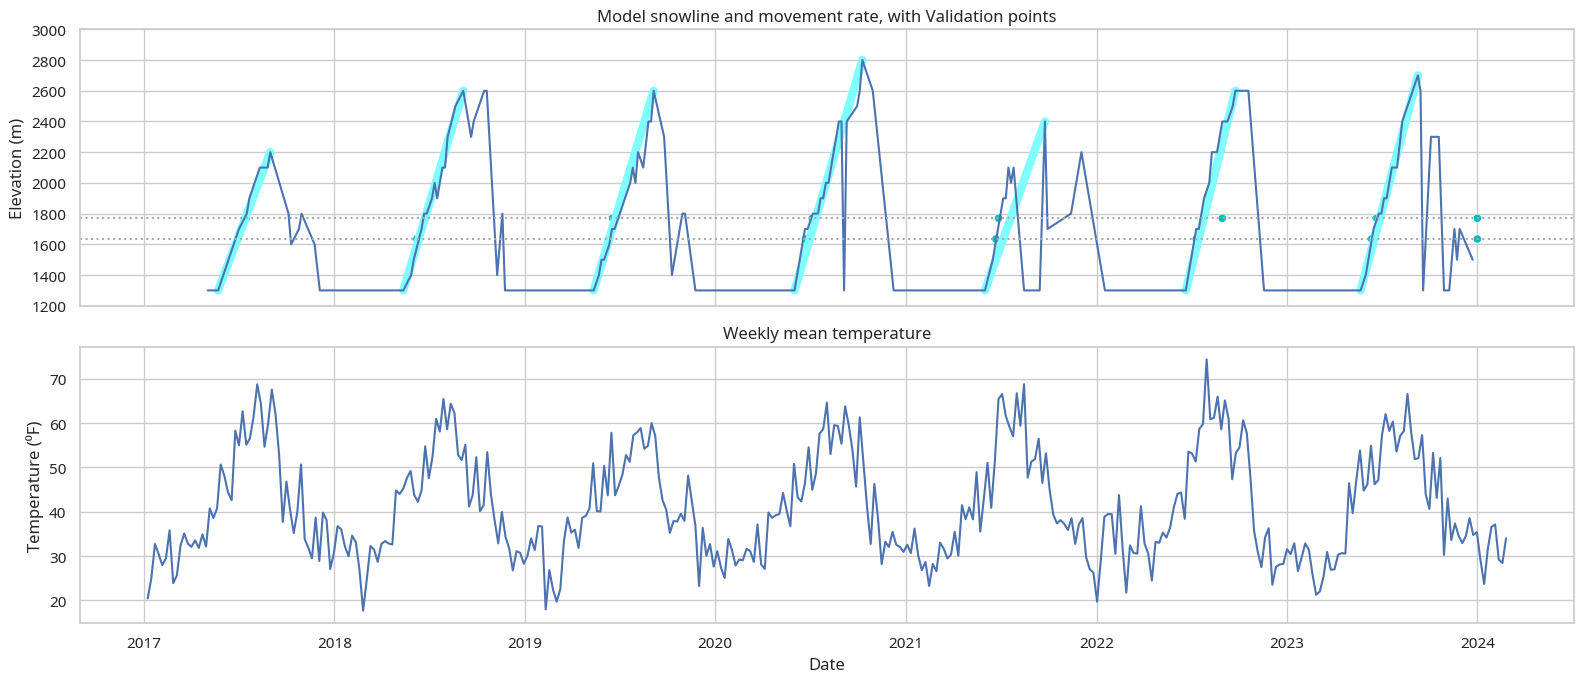

In [11]:
PLOT_ROWS = 2
fig, axes = plt.subplots(nrows=PLOT_ROWS, sharex=True)
fig.set_size_inches(w=FIG_WIDTH_IN, h=0.875*FIG_HEIGHT_IN*PLOT_ROWS)
# fig.subplots_adjust(hspace=0.7) # doesn't seem to be doing anything, maybe cause tight_layout

# create snowline plot
snowline_movement_lines(snowline_movement, ax=axes[0], color=(0.5, 1, 1))
snowline_lineplot(snowline, ax=axes[0])
# add annotations for validation sites
# the dots get placed under movement lines, but I can fix them in inkscape
# axes[0].vlines(x=all_no_snow["date"], ymin=1300, ymax=1635, colors="#0AA", linestyles="dotted")
for elev in all_no_snow["elev"].unique():
    axes[0].axhline(y=elev, color="#AAA", linestyle=":")
sb.scatterplot(all_no_snow, x="date", y="elev", hue="place", ax=axes[0],
               palette=sb.color_palette(["#0BB"]), legend=False)
axes[0].set_title("Model snowline and movement rate, with Validation points")

# create temperature plot
create_temp_lineplot(weather, places=["Snotel"], ax=axes[1])

plt.tight_layout()
# fig.savefig("media/linegraphs.svg", dpi=300, transparent=True)